In [1]:
include("./MPS.jl")
using .MPSforQuantum
using TensorOperations
using LinearAlgebra
using Plots

using PyCall
sympy = pyimport("sympy")

PyObject <module 'sympy' from '/Users/ryunagai/.julia/conda/3/lib/python3.7/site-packages/sympy/__init__.py'>

### Ising 相互作用(全結合) + 横磁場

シンボル変数の用意

In [2]:
N = 4
ops = ["X", "Y", "Z", "I"]
a = " "
for j = 1:4
    op = ops[j]
    for i = 1:N
        a = string(op, i)
        prog = string(op, "_ = sympy.Symbol(a)")
        prog = replace(prog, "_" => "$i")
        ex1 = Meta.parse(prog)
        #a = string(op, string(i))
        eval(ex1)
    end
end
J12 = sympy.Symbol("J12")
J23 = sympy.Symbol("J23")
J34 = sympy.Symbol("J34")
J13 = sympy.Symbol("J13")
J24 = sympy.Symbol("J24")
J14 = sympy.Symbol("J14")

PyObject J14

In [3]:
h = sympy.Symbol("h")

W1 = sympy.Matrix([[h*X1, J12*Z1, J13*Z1, J14*Z1, I1]])
W2 = sympy.Matrix([
        [I2, 0, 0, 0, 0],
        [Z2, 0, 0, 0, 0],
        [0, I2, 0, 0, 0],
        [0, 0, I2, 0, 0],
        [h*X2, J23*Z2, J24*Z2, 0, I2],
        ])
W3 = sympy.Matrix([
        [I3, 0, 0, 0, 0],
        [Z3, 0, 0, 0, 0],
        [0, I3, 0, 0, 0],
        [0, 0, I3, 0, 0],
        [h*X3, J34*Z3, 0, 0, I3],
        ])
W4 = sympy.Matrix([I4, Z4, 0, 0, h*X4])
sympy.expand(W1*W2*W3*W4)

PyObject Matrix([[I1*I2*I3*X4*h + I1*I2*I4*X3*h + I1*I2*J34*Z3*Z4 + I1*I3*I4*X2*h + I1*I3*J24*Z2*Z4 + I1*I4*J23*Z2*Z3 + I2*I3*I4*X1*h + I2*I3*J14*Z1*Z4 + I2*I4*J13*Z1*Z3 + I3*I4*J12*Z1*Z2]])

### Ising 相互作用項(NN, 一様)+横磁場

In [4]:
J = sympy.Symbol("J")

W1 = sympy.Matrix([[h*X1, J*Z1, I1]])
W2 = sympy.Matrix([
        [I2, 0, 0],
        [Z2, 0, 0],
        [h*X2, J*Z2, I2],
        ])
W3 = sympy.Matrix([
        [I3, 0, 0],
        [Z3, 0, 0],
        [h*X3, J*Z3, I3],
        ])
W4 = sympy.Matrix([I4, Z4, h*X4])
sympy.expand(W1*W2*W3*W4)

PyObject Matrix([[I1*I2*I3*X4*h + I1*I2*I4*X3*h + I1*I2*J*Z3*Z4 + I1*I3*I4*X2*h + I1*I4*J*Z2*Z3 + I2*I3*I4*X1*h + I3*I4*J*Z1*Z2]])

In [5]:
pauliX = convert(Array{ComplexF64,2}, [0 1; 1 0])
pauliY = convert(Array{ComplexF64,2}, [0 -1*im; 1*im 0])
pauliZ = convert(Array{ComplexF64,2}, [1 0; 0 -1])
pauliI = convert(Array{ComplexF64,2}, [1 0; 0 1])
zero = convert(Array{ComplexF64,2}, [0 0; 0 0])

function Ising_NN_Hamiltonian_MPO(N_sites::Int64, h::Float64, J::Float64)
    if N_sites < 2
        error("N_sites must be larger than 1")
    end
    O = []
    push!(O, dstack((h*pauliX, J*pauliZ, pauliI)) )
    for i = 1:(N_sites-2)
        push!(O, ddstack( [(pauliI, zero, zero), (pauliZ, zero, zero), (h*pauliX, J*pauliZ, pauliI)] ))
    end
    push!(O, dstack((pauliI, pauliZ, h*pauliX)))
    return O
end

Ising_NN_Hamiltonian_MPO (generic function with 1 method)

4 site で計算

In [6]:
D = 10
N = 4
C0 = zeros(ComplexF64, 2^N)
C0 = normalize!(rand(ComplexF64, 2^N))
mps = MPS(C0, D, 'r') # convert to MPS
O = Ising_NN_Hamiltonian_MPO(N, -0.01, -1.0)

(opt_mps, hist) = iterative_ground_state_search(mps, O, D, 1)

(Any[Array{Complex{Float64},2}[[0.5024911015464757 + 2.508861712867713e-17im -0.49749646079489473 - 2.5090165261169178e-17im], [0.5024968957765388 + 0.0im 0.4974905366920113 - 2.509199787946071e-19im]], Array{Complex{Float64},2}[[0.5011380204459124 - 7.537561530224585e-11im 0.4988535110191089 - 7.504713995849303e-11im 3.1021936831079643e-6 - 4.333683853266967e-16im -3.0841577070304733e-6 + 4.076943340119018e-16im; -0.49864339440584265 + 7.537659896871264e-11im -0.5013587779064287 + 7.504610997656417e-11im 3.149055092229989e-6 + 2.1868732379748495e-17im -3.1622106691459468e-6 + 1.0632939226526989e-15im], [0.5014335669048589 - 1.796614449067776e-13im -0.49856818686139576 - 5.807555726929505e-13im -3.1003642473696062e-6 + 1.0837038214034266e-13im -3.085922635176418e-6 + 1.0897419363625045e-13im; 0.4989286742294857 + 1.9721192457158449e-13im -0.501063188653254 - 2.0552517566934313e-13im 3.147253492316214e-6 - 1.104927756483854e-13im 3.1640760383733493e-6 - 1.1111946225724091e-13im]], Array

In [7]:
hist

4-element Array{Any,1}:
 -0.15074819102547574 - 1.734723475976807e-18im
  -3.0001500112490374 + 1.3715157666743342e-17im
  -3.0001500112490387 - 3.2444271309929774e-26im
   -3.000150011249039 - 1.2931007958382826e-26im

In [8]:
O_Z = []

# H = Z1 Z2 Z3 Z4 の期待値をとる
function pauliZ_measurement_MPO(N_sites::Int64)
    if N_sites < 2
        error("N_sites must be larger than 1")
    end
    O_Z = []
    push!(O_Z, dstack((pauliZ,)))
    for i = 1:(N_sites-2)
        push!(O_Z, ddstack( [(pauliZ,)] ) )
    end
    push!(O_Z, dstack( (pauliZ,) ))
    return O_Z
end

# H = Z1 + Z2 + Z3 + Z4
# 個々の量子ビットをpuli Z測定した値の和: magnetization に対応?
# Ising model では常にゼロ
function pauliZ_measurement_MPO_2(N_sites::Int64)
    if N_sites < 2
        error("N_sites must be larger than 1")
    end
    O_Z = []
    push!(O_Z, dstack((pauliZ, pauliI)))
    for i = 1:(N_sites-2)
        push!(O_Z, ddstack( [(pauliI, zero), (pauliZ, pauliI)] ) )
    end
    push!(O_Z, dstack( (pauliI, pauliZ) ))
    return O_Z
end

O_Z = pauliZ_measurement_MPO(N)
expectation(opt_mps, O_Z)

0.9998749903162423 + 0.0im

$h<<J$ レジームで計算した基底状態は$\frac{1}{\sqrt{2}} (|0000\rangle + |1111\rangle)$

In [9]:
print(restore(opt_mps, 0), '\n', restore(opt_mps, 15))

0.7070847045350944 - 1.0636252816410481e-10im
0.7070846541360519 - 1.0636251256481518e-10im

pauli Z測定の期待値を通して相転移を見る

In [10]:
function Ising_phase_transition(N_sites::Int64, D::Int64, h::Float64, J::Float64)
    C0 = zeros(ComplexF64, 2^N_sites)
    C0 = normalize!(rand(ComplexF64, 2^N_sites))
    mps = MPS(C0, D, 'r') # convert to MPS
    O = Ising_NN_Hamiltonian_MPO(N_sites, h, J)
    (opt_mps, hist) = iterative_ground_state_search(mps, O, D, 1)
    O_Z = pauliZ_measurement_MPO(N_sites)
    mag_z = expectation(opt_mps, O_Z)
    return mag_z
end

Ising_phase_transition (generic function with 1 method)

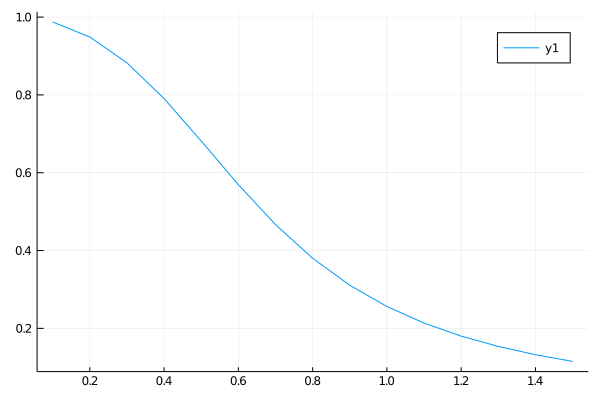

In [11]:
N = 4
D = 30
J = -1.0
measZ_list_MPS = []
h_list = []
for h = -0.1:-0.1:-1.5
    meas_z = Ising_phase_transition(N, D, h, J)
    push!(measZ_list_MPS, meas_z.re)
    push!(h_list, -h)
end

plot(h_list, measZ_list_MPS)

同様の相転移を古典計算で確認

In [12]:
function td(x::Array, y::Array)
    lx = size(x)
    ly = size(y)
    res = zeros(lx[1] * ly[1], lx[2] * ly[2])
    for i in 1:lx[1]
        for j in 1:lx[2]
            res[ (1+(i-1)*ly[1]):(ly[1]+(i-1)*ly[1]), (1+(j-1)*ly[2]):(ly[2]+(j-1)*ly[2]) ] = x[i,j] * y
        end
    end
    return res
end

function Ising_NN_Hamiltonian(h, J)
    H = J*(td(td(td(pauliZ, pauliZ), pauliI), pauliI) + td(td(td(pauliI, pauliZ), pauliZ), pauliI) + td(td(td(pauliI, pauliI), pauliZ), pauliZ))
    H += h*(td(td(td(pauliX, pauliI), pauliI), pauliI) + td(td(td(pauliI, pauliX), pauliI), pauliI))
    H += h*(td(td(td(pauliI, pauliI), pauliX), pauliI) + td(td(td(pauliI, pauliI), pauliI), pauliX))
    return H
end

function pauliZ_measure()
    measZ = td(td(td(pauliZ, pauliZ), pauliZ), pauliZ)
    return measZ
end

pauliZ_measure (generic function with 1 method)

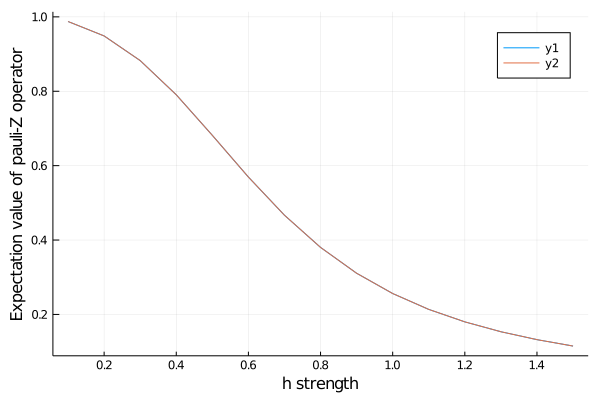

In [13]:
expc_list = []
h_list = []
for h = -0.1:-0.1:-1.5
    H = Ising_NN_Hamiltonian(h, -1.0)
    vec = eigvecs(H)[:, 1]
    measZ = pauliZ_measure()
    expc = transpose(vec) * measZ * vec
    push!(expc_list, expc)
    push!(h_list, -h)
end
plot!(h_list, expc_list)
xlabel!("h strength")
ylabel!("Expectation value of pauli-Z operator")

もっと大きな規模で

In [ ]:
D = 10
N = 50
mps = init_MPS(N, D, 'r') # convert to MPS
O = Ising_NN_Hamiltonian_MPO(N, -0.001, -1.0)

(opt_mps, hist) = iterative_ground_state_search(mps, O, D, 1)

In [15]:
hist

50-element Array{Any,1}:
 -0.6032421605400494 - 2.7755575615628914e-17im
 -49.001300008263755 + 2.4619187244317582e-14im
 -49.001300008263755 + 2.4591428199072067e-14im
 -49.001300008263755 + 2.0872185139637147e-14im
 -49.001300008263726 + 2.076115995861496e-14im
 -49.001300008263726 + 1.726395327204209e-14im
  -49.00130000826375 + 1.5598622083861237e-14im
 -49.001300008263776 + 1.9040313236496493e-14im
  -49.00130000826378 + 1.376675342523483e-14im
  -49.00130000826382 + 1.0713651328476489e-14im
  -49.00130000826379 + 9.159322696295703e-15im
   -49.0013000082638 + 9.936478881305377e-15im
 -49.001300008263776 + 1.1712828337591379e-14im
                     ⋮
  -49.00130000826411 + 3.885865129897228e-15im
 -49.001300008264096 + 2.664592634777753e-15im
 -49.001300008264124 + 2.5605176776129405e-15im
 -49.001300008264145 + 2.3037728442001434e-15im
  -49.00130000826419 + 2.1649961403388893e-15im
   -49.0013000082642 + 2.4425554314439216e-15im
  -49.00130000826423 + 6.106380759903186e-16im


### 1-D J1J2 model

$H = \sum_{<i,j>} J_1 (\sigma^x_i \sigma^x_{j}+\sigma^y_i \sigma^y_{j}+\sigma^z_i \sigma^z_{j}) + \sum_{<<i,j>>} J_2 (\sigma^x_i \sigma^x_{j}+\sigma^y_i \sigma^y_{j}+\sigma^z_i \sigma^z_{j})$

In [36]:
j1 = 1
j2 = 0.5
N = 5

O = []
mid_MPO = [(pauliI, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero),
    (pauliX, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero), 
    (zero, pauliI, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero), 
    (zero, j1*pauliX, j2*pauliX, pauliI, zero, zero, zero, zero, zero, zero, zero, zero),
    (zero, zero, zero, zero, pauliI, zero, zero, zero, zero, zero, zero, zero),
    (zero, zero, zero, zero, pauliY, zero, zero, zero, zero, zero, zero, zero),
    (zero, zero, zero, zero, zero, pauliI, zero, zero, zero, zero, zero, zero),
    (zero, zero, zero, zero, zero, j1*pauliY, j2*pauliY, pauliI, zero, zero, zero, zero),
    (zero, zero, zero, zero, zero, zero, zero, zero, pauliI, zero, zero, zero),
    (zero, zero, zero, zero, zero, zero, zero, zero, pauliZ, zero, zero, zero),
    (zero, zero, zero, zero, zero, zero, zero, zero, zero, pauliI, zero, zero),
    (zero, zero, zero, zero, zero, zero, zero, zero, zero, j1*pauliZ, j2*pauliZ, pauliI)] 

push!(O, dstack((zero, j1*pauliX, j2*pauliX, pauliI, zero, j1*pauliY, j2*pauliY, pauliI, zero, j1*pauliZ, j2*pauliZ, pauliI)) )
for i = 1:N-2
    push!(O, ddstack(mid_MPO))
end
push!(O, dstack((pauliI, pauliX, zero, zero, pauliI, pauliY, zero, zero, pauliI, pauliZ, zero, zero)))

5-element Array{Any,1}:
 Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 0.5 + 0.0im; 0.5 + 0.0im 0.0 + 0.0im]

...

Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im]

Complex{Float64}[0.5 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -0.5 + 0.0im]

Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im]
 Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

...

Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

Complex{Float64}[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]

Complex{Flo

In [41]:
D = 20
C0 = zeros(ComplexF64, 2^N)
#C0[2] = 1 # computational basis
C0 = normalize!(rand(ComplexF64, 2^N))
mps = MPS(C0, D, 'r') # convert to MPS

(opt_mps, hist) = iterative_ground_state_search(mps, O, D)

(Any[Array{Complex{Float64},2}[[0.02695038404993947 + 0.016086614651361023im -0.4701157208004061 - 0.2806108598693105im], [0.8359671738876949 + 0.0im 0.020555685115332963 + 0.0im]], Array{Complex{Float64},2}[[0.3222261831752922 + 0.8857242247609809im -0.004881041715452988 - 0.01125294307884915im -0.02982677958366048 - 0.051308780621374395im 1.6284716630732277e-16 + 9.150666335777657e-17im; 0.012692192669086947 + 0.034887861692574115im 2.4836361266211693e-16 + 2.167862243884766e-16im 0.002488575973353273 + 0.004280911330647174im -0.05873500327610394 - 0.0011249565804398356im], [-0.02743220594652914 - 0.022353843744149664im -0.26524790816469557 - 0.19072641518931963im 0.0019489135431753248 + 0.0010801613527799308im -2.3107058801097313e-18 + 4.1565600787663026e-17im; 0.7665379229791712 + 0.6246332864241047im 5.997806418189811e-16 + 5.273559366969494e-16im 0.11535440846133933 + 0.0639337616228039im 0.0019151800315657965 - 0.0010939775877965im]], Array{Complex{Float64},2}[[0.005216923900185

In [42]:
hist

10-element Array{Any,1}:
   4.53564159467768 - 2.220446049250313e-16im
 -0.324148481609576 + 2.3245294578089215e-16im
 -5.823706043321047 + 1.1102230246251565e-16im
 -6.709049769721576 + 1.1102230246251565e-16im
 -6.709049769721587 - 4.440892098500626e-16im
 -6.709049769721581 - 4.440892098500626e-16im
 -6.709049769721577 + 4.440892098500626e-16im
 -6.709049769721576 + 0.0im
 -6.709049769721576 + 0.0im
 -6.709049769721569 - 4.440892098500626e-16im